# Лабораторная работа №4 (подчищено) + кластеризация (KMeans, DBSCAN, Agglomerative) на Spotify

Датасет: `spotify_data_clean.csv`

**Часть A — обучение с учителем (классификация):** предсказание признака `explicit` (наличие ненормативной лексики).  
**Часть B — обучение без учителя (кластеризация):** те же данные, но **без использования целевой метки `y` при обучении**. После обучения сравниваем кластеры с истинными метками.

> Примечание: в моделирование не включаем идентификаторы и текстовые поля (`track_id`, `track_name`, `artist_name`, `album_id`, `album_name`), чтобы не «запоминать» уникальные объекты и не раздувать размерность.


In [35]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import itertools


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    f1_score, roc_auc_score
)

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score


## 0–1. Описание задачи и чтение данных

**Задача (классификация):** по признакам трека определить `explicit` (True/False).

In [36]:
df = pd.read_csv(r"spotify_data_clean.csv")
df.head(), df.shape

(                 track_id                                       track_name  \
 0  3EJS5LyekDim1Tf5rBFmZl                    Trippy Mane (ft. Project Pat)   
 1  1oQW6G2ZiwMuHqlPpP27DB                                             OMG!   
 2  7mdkjzoIYlf1rx9EtBpGmU                                      Hard 2 Find   
 3  67rW0Zl7oB3qEpD5YWWE5w  Still Get Like That (ft. Project Pat & Starrah)   
 4  15xptTfRBrjsppW0INUZjf                            ride me like a harley   
 
    track_number  track_popularity  explicit artist_name  artist_popularity  \
 0             4                 0      True       Diplo                 77   
 1             1                 0      True    Yelawolf                 64   
 2             1                 4      True   Riff Raff                 48   
 3             8                30      True       Diplo                 77   
 4             2                 0      True     Rumelis                 48   
 
    artist_followers                      artist

## 2. EDA: первичный анализ, статистики, пропуски, распределения

In [37]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            8582 non-null   object 
 1   track_name          8582 non-null   object 
 2   track_number        8582 non-null   int64  
 3   track_popularity    8582 non-null   int64  
 4   explicit            8582 non-null   bool   
 5   artist_name         8579 non-null   object 
 6   artist_popularity   8582 non-null   int64  
 7   artist_followers    8582 non-null   int64  
 8   artist_genres       5221 non-null   object 
 9   album_id            8582 non-null   object 
 10  album_name          8582 non-null   object 
 11  album_release_date  8582 non-null   object 
 12  album_total_tracks  8582 non-null   int64  
 13  album_type          8582 non-null   object 
 14  track_duration_min  8582 non-null   float64
dtypes: bool(1), float64(1), int64(5), object(8)
memory usag

In [38]:
# Пропуски
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

artist_genres    3361
artist_name         3
dtype: int64

In [39]:
# Приведём дату к datetime и выделим год релиза как числовой признак
df["album_release_date"] = pd.to_datetime(df["album_release_date"], errors="coerce")
df["release_year"] = df["album_release_date"].dt.year

# Цель
y = df["explicit"].astype(int)

# Исключаем очевидно «текстовые» и ID-поля
drop_cols = ["explicit", "track_id", "track_name", "artist_name", "album_id", "album_name", "album_release_date"]
X = df.drop(columns=drop_cols)

X.head(), X.shape

(   track_number  track_popularity  artist_popularity  artist_followers  \
 0             4                 0                 77           2812821   
 1             1                 0                 64           2363438   
 2             1                 4                 48            193302   
 3             8                30                 77           2813710   
 4             2                 0                 48              8682   
 
                        artist_genres  album_total_tracks album_type  \
 0                         moombahton                   9      album   
 1  country hip hop, southern hip hop                   1     single   
 2                                NaN                   1     single   
 3                         moombahton                   9      album   
 4                           dark r&b                   2     single   
 
    track_duration_min  release_year  
 0                1.55          2025  
 1                3.07          2025

In [40]:
# Основные статистики по числовым признакам
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
X[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
track_number,8582.0,5.772547e+00,6.052792e+00,1.00,1.00,4.000,9.00,1.020000e+02
track_popularity,8582.0,5.235621e+01,2.381608e+01,0.00,39.00,58.000,71.00,9.900000e+01
artist_popularity,8582.0,6.973002e+01,1.964598e+01,0.00,60.00,74.000,84.00,1.000000e+02
artist_followers,8582.0,2.403472e+07,3.803180e+07,0.00,462320.00,6105547.000,27252551.00,1.455421e+08
album_total_tracks,8582.0,1.378944e+01,1.188713e+01,1.00,6.00,13.000,17.00,1.810000e+02
track_duration_min,8582.0,3.492805e+00,1.057970e+00,0.07,2.88,3.445,3.99,1.351000e+01


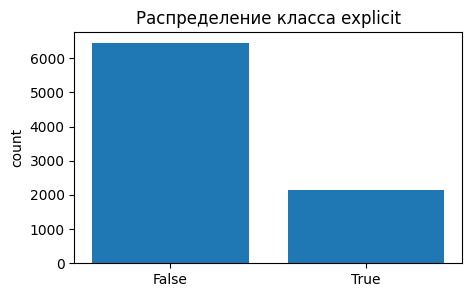

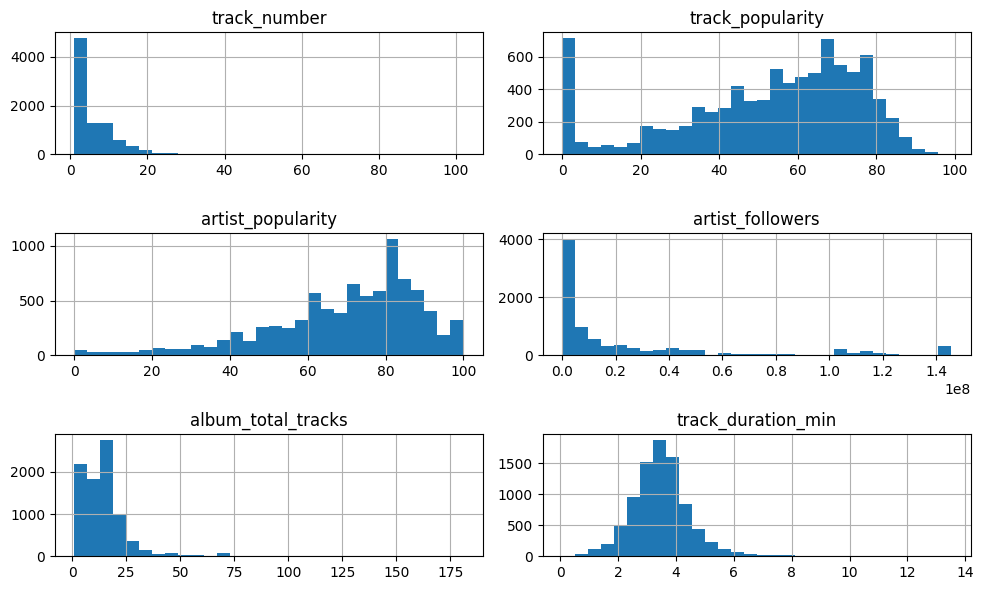

In [41]:
# Распределение целевого класса
plt.figure(figsize=(5,3))
counts = df["explicit"].value_counts()
plt.bar(["False", "True"], counts.values)
plt.title("Распределение класса explicit")
plt.ylabel("count")
plt.show()

# Гистограммы числовых признаков
X[num_cols].hist(figsize=(10,6), bins=30)
plt.tight_layout()
plt.show()

In [42]:
# Корреляции (только числовые признаки)
corr = X[num_cols].corr()
corr

,track_number,track_popularity,artist_popularity,artist_followers,album_total_tracks,track_duration_min
track_number,1.000000,-0.028513,0.190696,0.222508,0.520070,0.070122
track_popularity,-0.028513,1.000000,0.466903,0.232019,-0.053461,0.105560
artist_popularity,0.190696,0.466903,1.000000,0.635579,0.199335,0.207769
artist_followers,0.222508,0.232019,0.635579,1.000000,0.183718,0.172140
album_total_tracks,0.520070,-0.053461,0.199335,0.183718,1.000000,0.064824
track_duration_min,0.070122,0.105560,0.207769,0.172140,0.064824,1.000000


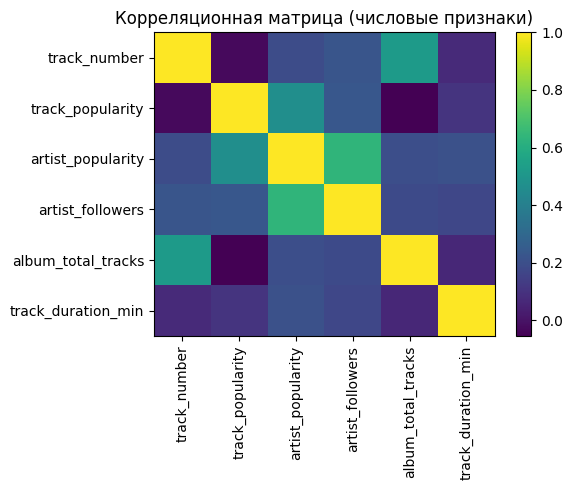

In [43]:
plt.figure(figsize=(6,5))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Корреляционная матрица (числовые признаки)")
plt.tight_layout()
plt.show()

## 3. Обработка пропусков

В этом датасете после чтения и преобразований проверяем, что ключевые признаки не содержат пропусков. Если `release_year` не распарсился — заполним медианой.

In [44]:
# Заполнение release_year (если вдруг появились NaN после парсинга)
if X["release_year"].isna().any():
    X["release_year"] = X["release_year"].fillna(X["release_year"].median())

X.isna().sum().sort_values(ascending=False).head(10)

artist_genres         3361
track_number             0
track_popularity         0
artist_popularity        0
artist_followers         0
album_total_tracks       0
album_type               0
track_duration_min       0
release_year             0
dtype: int64

## 4. Категориальные признаки

`artist_genres` и `album_type` — категориальные.  
Чтобы не раздувать размерность, оставим **топ-N жанров**, остальные сведём в `other`.

In [45]:
# Упрощаем artist_genres: оставим топ-20, остальное -> 'other'
top_n = 20
top_genres = X["artist_genres"].value_counts().head(top_n).index
X["artist_genres"] = X["artist_genres"].where(X["artist_genres"].isin(top_genres), "other")

cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()
cat_cols

['artist_genres', 'album_type']

## 5. Нормализация

Для **kNN** и логистической регрессии масштабирование числовых признаков важно, поэтому применяем `StandardScaler` внутри пайплайна.

## 6. Train/Test split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((6865, 9), (1717, 9))

In [47]:
# Препроцессор: числовые -> StandardScaler, категориальные -> OneHotEncoder
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)


## 7–9. kNN-классификатор + подбор `n_neighbors` + ошибки на train/test

In [48]:
knn_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", KNeighborsClassifier())
])

param_grid = {
    "clf__n_neighbors": list(range(1, 31, 2)),
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2],  # Manhattan vs Euclidean
}

grid = GridSearchCV(
    knn_pipe, param_grid=param_grid, cv=5, scoring="f1", n_jobs=-1
)
grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_

({'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'uniform'},
 np.float64(0.5039029971779605))

In [49]:
best_knn = grid.best_estimator_
y_pred_train = best_knn.predict(X_train)
y_pred_test = best_knn.predict(X_test)

print("kNN best params:", grid.best_params_)
print("Train accuracy:", accuracy_score(y_train, y_pred_train), "F1:", f1_score(y_train, y_pred_train))
print("Test  accuracy:", accuracy_score(y_test, y_pred_test), "F1:", f1_score(y_test, y_pred_test))
print("\nConfusion matrix (test):\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification report (test):\n", classification_report(y_test, y_pred_test))

kNN best params: {'clf__n_neighbors': 3, 'clf__p': 1, 'clf__weights': 'uniform'}
Train accuracy: 0.8782228696285507 F1: 0.7311897106109325
Test  accuracy: 0.7757716948165405 F1: 0.4873501997336884

Confusion matrix (test):
 [[1149  138]
 [ 247  183]]

Classification report (test):
               precision    recall  f1-score   support

           0       0.82      0.89      0.86      1287
           1       0.57      0.43      0.49       430

    accuracy                           0.78      1717
   macro avg       0.70      0.66      0.67      1717
weighted avg       0.76      0.78      0.76      1717



## 10–11. Другие классификаторы и дисбаланс классов

Проверим ещё 2 модели:
- `LogisticRegression` (с `class_weight="balanced"`)
- `RandomForestClassifier` (с `class_weight="balanced_subsample"`)

Сравним по F1 на тесте.

In [50]:
models = {
    "LogReg_balanced": Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "RF_balanced": Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=400,
            random_state=42,
            class_weight="balanced_subsample",
            n_jobs=-1
        ))
    ])
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results.append((name, accuracy_score(y_test, pred), f1_score(y_test, pred)))

pd.DataFrame(results, columns=["model", "accuracy_test", "f1_test"]).sort_values("f1_test", ascending=False)

,model,accuracy_test,f1_test
1,RF_balanced,0.818288,0.530120
0,LogReg_balanced,0.637158,0.493907


## 12. Исключение коррелированных переменных

Зачем: сильно коррелированные признаки часто дублируют информацию, могут ухудшать интерпретируемость и иногда стабильность моделей.  
Покажем пары с высокой корреляцией и (для примера) удалим один из признаков при |corr| > 0.9.

In [51]:
corr = X[num_cols].corr().abs()

# Найдём пары (i<j) с корреляцией выше порога
thr = 0.90
pairs = []
for i in range(len(num_cols)):
    for j in range(i+1, len(num_cols)):
        c = corr.iloc[i, j]
        if c >= thr:
            pairs.append((num_cols[i], num_cols[j], c))

pd.DataFrame(pairs, columns=["feat_1", "feat_2", "abs_corr"]).sort_values("abs_corr", ascending=False)

,feat_1,feat_2,abs_corr


In [52]:
# Если пары есть — удалим второй признак в каждой паре (пример)
to_drop = []
for a, b, c in pairs:
    to_drop.append(b)
to_drop = sorted(set(to_drop))
to_drop

[]

## 13. Общие выводы (по классификации)

- По результатам сравнения выбираем модель с лучшим F1 на тесте (важно при дисбалансе).
- Масштабирование оказалось критичным для kNN.
- Балансировка через `class_weight` помогает учитывать редкий класс без явного оверсэмплинга.


# Часть B — Кластеризация (без использования y при обучении)

Требования:
- Решить задачу кластеризации **3 методами**: `KMeans`, `DBSCAN` и ещё один (возьмём `AgglomerativeClustering`).
- Использовать **PCA** для понижения размерности и визуализации.
- При обучении без учителя **не использовать** метку `explicit`.
- После кластеризации сравнить кластеры с истинными метками `explicit` (ARI, NMI и т.п.).


In [53]:
# Подготовим признаки (без explicit!)
X_unsup = df.drop(columns=drop_cols)  # drop_cols уже содержит explicit и текстовые поля
X_unsup["release_year"] = pd.to_datetime(df["album_release_date"], errors="coerce").dt.year
if X_unsup["release_year"].isna().any():
    X_unsup["release_year"] = X_unsup["release_year"].fillna(X_unsup["release_year"].median())

# Ограничим топ-жанры и для unsupervised так же
top_genres = X_unsup["artist_genres"].value_counts().head(top_n).index
X_unsup["artist_genres"] = X_unsup["artist_genres"].where(X_unsup["artist_genres"].isin(top_genres), "other")

num_cols_u = X_unsup.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_u = X_unsup.select_dtypes(include=["object", "bool"]).columns.tolist()

preprocessor_u = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_u),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols_u),
    ],
    remainder="drop"
)

X_u = preprocessor_u.fit_transform(X_unsup)
X_u.shape

(8582, 30)

Explained variance ratio: [0.33633742 0.20841801] sum: 0.5447554249684008


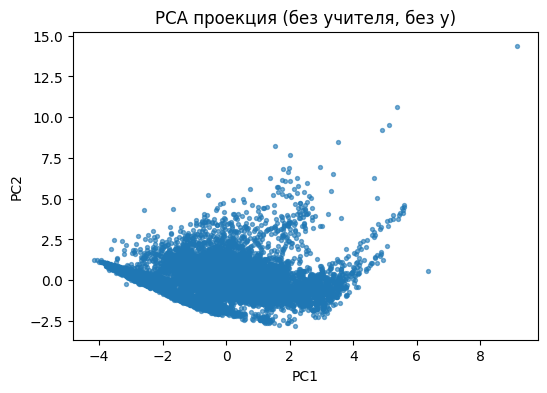

In [54]:
# PCA до 2 компонент для визуализации
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_u)

print("Explained variance ratio:", pca.explained_variance_ratio_, "sum:", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], s=8, alpha=0.6)
plt.title("PCA проекция (без учителя, без y)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [55]:
def clustering_accuracy_via_permutation(y_true, y_pred):
    """Лучшая accuracy при сопоставлении меток кластеров меткам классов.
    Работает для небольшого числа кластеров (перебор перестановок).
    DBSCAN-метку -1 (noise) оставляем как отдельную метку.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    uniq_pred = np.unique(y_pred)
    # Если кластеров слишком много — accuracy по перебору может быть дорогой.
    if len(uniq_pred) > 10:
        return np.nan

    best = 0.0
    # сопоставляем кластеры -> классы
    uniq_true = np.unique(y_true)
    # если кластеров больше, чем классов, часть кластеров будет сопоставлена одному классу через перебор подмножеств — усложним:
    # для этой работы достаточно сравнивать ARI/NMI, accuracy оставим только когда кластеров == числу классов
    if len(uniq_pred) != len(uniq_true):
        return np.nan

    for perm in itertools.permutations(uniq_true, len(uniq_pred)):
        mapping = dict(zip(uniq_pred, perm))
        mapped = np.vectorize(mapping.get)(y_pred)
        acc = (mapped == y_true).mean()
        if acc > best:
            best = acc
    return best


In [56]:
# ---- 1) KMeans ----
# Подберём k по silhouette на PCA-проекции (простая и наглядная стратегия)
sil = []
k_list = list(range(2, 9))
for k in k_list:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_pca)
    sil.append(silhouette_score(X_pca, labels))

pd.DataFrame({"k": k_list, "silhouette": sil}).sort_values("silhouette", ascending=False)

,k,silhouette
6,8,0.371780
3,5,0.362269
2,4,0.358383
1,3,0.356654
4,6,0.355725
5,7,0.344448
0,2,0.340482


KMeans best_k: 8
ARI: 0.0042320463167597935
NMI: 0.021112285262212493
Best-mapped accuracy (only if #clusters == #classes): nan


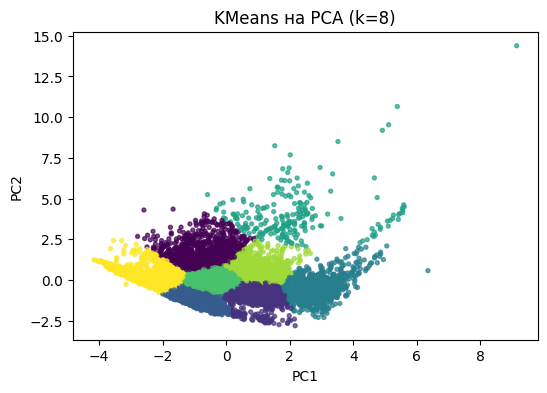

In [57]:
best_k = k_list[int(np.argmax(sil))]
kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

print("KMeans best_k:", best_k)
print("ARI:", adjusted_rand_score(y, kmeans_labels))
print("NMI:", normalized_mutual_info_score(y, kmeans_labels))
print("Best-mapped accuracy (only if #clusters == #classes):", clustering_accuracy_via_permutation(y, kmeans_labels))

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, s=8, alpha=0.7)
plt.title(f"KMeans на PCA (k={best_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [58]:
# ---- 2) DBSCAN ----
# Простой подбор eps: переберём несколько значений и выберем по silhouette (игнорируя ситуации, когда все в одном кластере)
eps_grid = np.linspace(0.3, 2.0, 18)
best = None

for eps in eps_grid:
    db = DBSCAN(eps=float(eps), min_samples=10)
    labels = db.fit_predict(X_pca)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:
        continue
    # silhouette требует как минимум 2 кластера (noise считаем как отдельную метку -1)
    score = silhouette_score(X_pca, labels)
    row = (eps, n_clusters, (labels == -1).mean(), score)
    if (best is None) or (score > best[-1]):
        best = row

best

(np.float64(0.5), 3, np.float64(0.005942670706129107), 0.5782546585646248)

DBSCAN best eps=0.500, clusters=3, noise=0.59%, silhouette=0.578
ARI: -0.010247647391949728
NMI: 0.006414707879059448


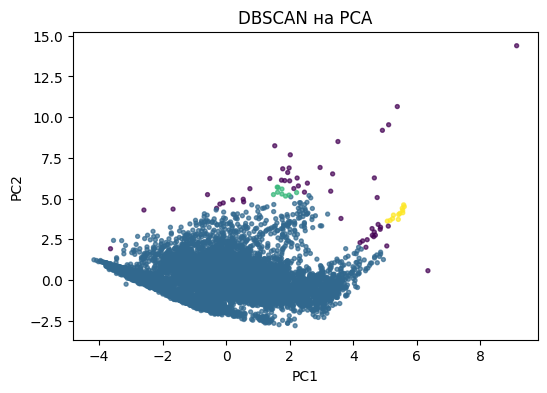

In [59]:
if best is None:
    print("DBSCAN: не удалось подобрать eps с >=2 кластерами.")
    dbscan_labels = np.full_like(y, fill_value=-1)
else:
    best_eps, n_cl, noise_rate, sil_best = best
    dbscan = DBSCAN(eps=float(best_eps), min_samples=10)
    dbscan_labels = dbscan.fit_predict(X_pca)
    print(f"DBSCAN best eps={best_eps:.3f}, clusters={n_cl}, noise={noise_rate:.2%}, silhouette={sil_best:.3f}")
    print("ARI:", adjusted_rand_score(y, dbscan_labels))
    print("NMI:", normalized_mutual_info_score(y, dbscan_labels))

    plt.figure(figsize=(6,4))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=dbscan_labels, s=8, alpha=0.7)
    plt.title("DBSCAN на PCA")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

Agglomerative (ward) clusters: 2
ARI: 0.0039046022351906327
NMI: 0.0019060537056311627
Best-mapped accuracy: 0.5341412258214868


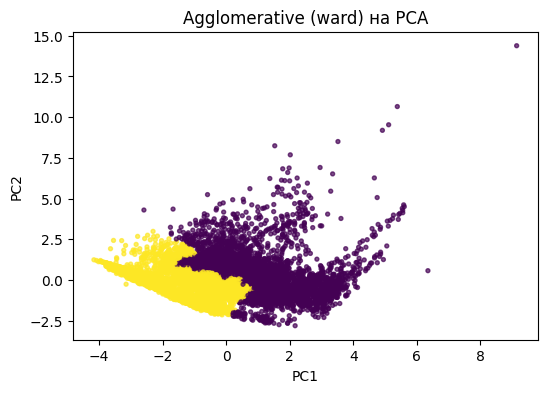

In [60]:
# ---- 3) AgglomerativeClustering ----
# Возьмём число кластеров равным числу истинных классов (2), чтобы сравнение было честнее по смыслу.
agg = AgglomerativeClustering(n_clusters=len(np.unique(y)), linkage="ward")
agg_labels = agg.fit_predict(X_pca)

print("Agglomerative (ward) clusters:", len(np.unique(agg_labels)))
print("ARI:", adjusted_rand_score(y, agg_labels))
print("NMI:", normalized_mutual_info_score(y, agg_labels))
print("Best-mapped accuracy:", clustering_accuracy_via_permutation(y, agg_labels))

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=agg_labels, s=8, alpha=0.7)
plt.title("Agglomerative (ward) на PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

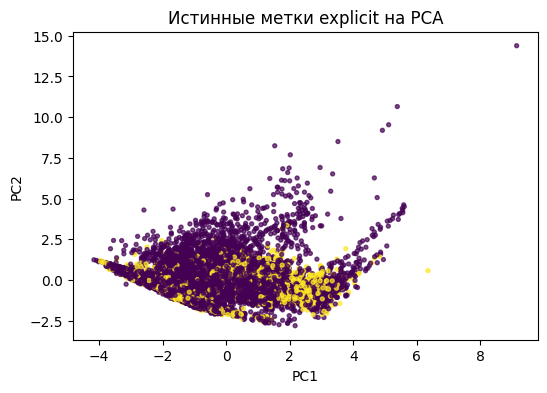

In [61]:
# Для сравнения: визуализация истинных меток на PCA
plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=8, alpha=0.7)
plt.title("Истинные метки explicit на PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

## Выводы (кластеризация)

- Метрики **ARI** и **NMI** показывают, насколько разбиение на кластеры согласуется с истинными метками `explicit` (без подгонки меток).
- `KMeans` и `Agglomerative` требуют заранее заданного числа кластеров; `DBSCAN` умеет находить «шум» и кластеры произвольной формы, но чувствителен к параметрам `eps`/`min_samples`.
- PCA до 2 компонент — это компромисс: удобно визуализировать, но часть информации теряется (поэтому ARI/NMI могут быть ниже, чем при кластеризации в исходном пространстве).
